# ResNet50 Model

In [1]:
import numpy as np
import pandas as pd
import os
import random

In [2]:
#Other necessary imports
import matplotlib.pyplot as plt

from PIL import Image
import keras
from keras import models
from keras import layers
from keras.applications.resnet import ResNet50
from keras.layers import Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Defining a results visualization function
def visualize_results(history):
   
    #Instantiate values
    train_loss = history.history['loss']
    train_acc = history.history['accuracy']
    train_recall = history.history['recall']
    train_aucroc = history.history['auc']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    val_recall = history.history['val_recall']
    val_aucroc = history.history['val_auc']
    
    #Create figure for plotting
    fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Results')
    #plt.xlabel('Epoch')
    
    #Plot Loss
    ax1.plot(train_loss)
    ax1.plot(val_loss)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epochs')
    ax1.legend(['train', 'val'])
    
    #Plot Accuracy
    ax2.plot(train_acc)
    ax2.plot(val_acc)
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.legend(['train', 'val'])
    
    #Plot Recall
    ax3.plot(train_recall)
    ax3.plot(val_recall)
    ax3.set_ylabel('Recall')
    ax3.set_xlabel('Epochs')
    ax3.legend(['train', 'val'])
    
    #Plot AUC-ROC
    ax4.plot(train_aucroc)
    ax4.plot(val_aucroc)
    ax4.set_ylabel('AUC-ROC')
    ax4.set_xlabel('Epochs')
    ax4.legend(['train', 'val'])
    
    plt.show();

# Load Processed Data

In [4]:
import pandas as pd

# Load the training metadata and ground truth CSV files
train_metadata = pd.read_csv("C:/Users/IMRAN/Partion 2/UNHAS/MKPK/KP/WEEK3/Dataset/ISIC_2019_Training_Metadata.csv")
train_groundtruth = pd.read_csv("C:/Users/IMRAN/Partion 2/UNHAS/MKPK/KP/WEEK3/Dataset/ISIC_2019_Training_GroundTruth.csv")

In [5]:
# Display first few rows of each DataFrame
print("Training Metadata:")
print(train_metadata.head())

print("\nTraining GroundTruth:")
print(train_groundtruth.head())

Training Metadata:
          image  age_approx anatom_site_general lesion_id     sex
0  ISIC_0000000        55.0      anterior torso       NaN  female
1  ISIC_0000001        30.0      anterior torso       NaN  female
2  ISIC_0000002        60.0     upper extremity       NaN  female
3  ISIC_0000003        30.0     upper extremity       NaN    male
4  ISIC_0000004        80.0     posterior torso       NaN    male

Training GroundTruth:
          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0


In [6]:
# Merge metadata with ground truth on the 'image' column
train_data = pd.merge(train_metadata, train_groundtruth, on='image')

# Display first few rows of the merged DataFrame
print("\nMerged Training Data:")
print(train_data.head())



Merged Training Data:
          image  age_approx anatom_site_general lesion_id     sex  MEL   NV  \
0  ISIC_0000000        55.0      anterior torso       NaN  female  0.0  1.0   
1  ISIC_0000001        30.0      anterior torso       NaN  female  0.0  1.0   
2  ISIC_0000002        60.0     upper extremity       NaN  female  1.0  0.0   
3  ISIC_0000003        30.0     upper extremity       NaN    male  0.0  1.0   
4  ISIC_0000004        80.0     posterior torso       NaN    male  1.0  0.0   

   BCC   AK  BKL   DF  VASC  SCC  UNK  
0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0   0.0  0.0  0.0  


In [7]:
# Display the shape of the merged DataFrame
print(f"Shape of the merged DataFrame: {train_data.shape}")

Shape of the merged DataFrame: (25331, 14)


# Data Preprocessing

In [8]:
# Apply necessary transformations and augmentations
from tensorflow import keras
import numpy as np
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
#from keras.applications import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os

# Define the paths to the images
train_images_dir = "C:/Users/IMRAN/Partion 2/UNHAS/MKPK/KP/WEEK3/Dataset/ISIC_2019_Training_Input"
test_images_dir = "C:/Users/IMRAN/Partion 2/UNHAS/MKPK/KP/WEEK3/Dataset/ISIC_2019_Test_Input"

# Ensure the image filenames have the correct format (append .jpg if necessary)
train_data['image'] = train_data['image'].apply(lambda x: x + '.jpg')

# Create the full path for each image
train_data['image_path'] = train_data['image'].apply(lambda x: os.path.join(train_images_dir, x))

# Split the data into training and validation sets
train_df, val_df = train_test_split(train_data, test_size=0.2,
                                    stratify=train_data[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']])

# ImageDataGenerator for training and validation with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1. / 255)

# Create the training and validation generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,  # Images are already included in image_path column
    x_col='image_path',
    y_col=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    target_size=(224, 224),  # Resize images to match VGG16 input size
    batch_size=32,
    class_mode='raw',  # For multi-output regression/classification
    shuffle=True
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,  # Images are already included in image_path column
    x_col='image_path',
    y_col=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    target_size=(224, 224),  # Resize images to match VGG16 input size
    batch_size=32,
    class_mode='raw',  # For multi-output regression/classification
    shuffle=False
)


Found 20264 validated image filenames.
Found 5067 validated image filenames.


In [9]:
print(f"Training samples: {train_generator.n}")
print(f"Validation samples: {validation_generator.n}")

print(f"Training steps per epoch: {len(train_generator)}")
print(f"Validation steps: {len(validation_generator)}")

Training samples: 20264
Validation samples: 5067
Training steps per epoch: 634
Validation steps: 159


In [10]:
x_batch, y_batch = next(train_generator)
print(f"x_batch shape: {x_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")

x_batch shape: (32, 224, 224, 3)
y_batch shape: (32, 8)


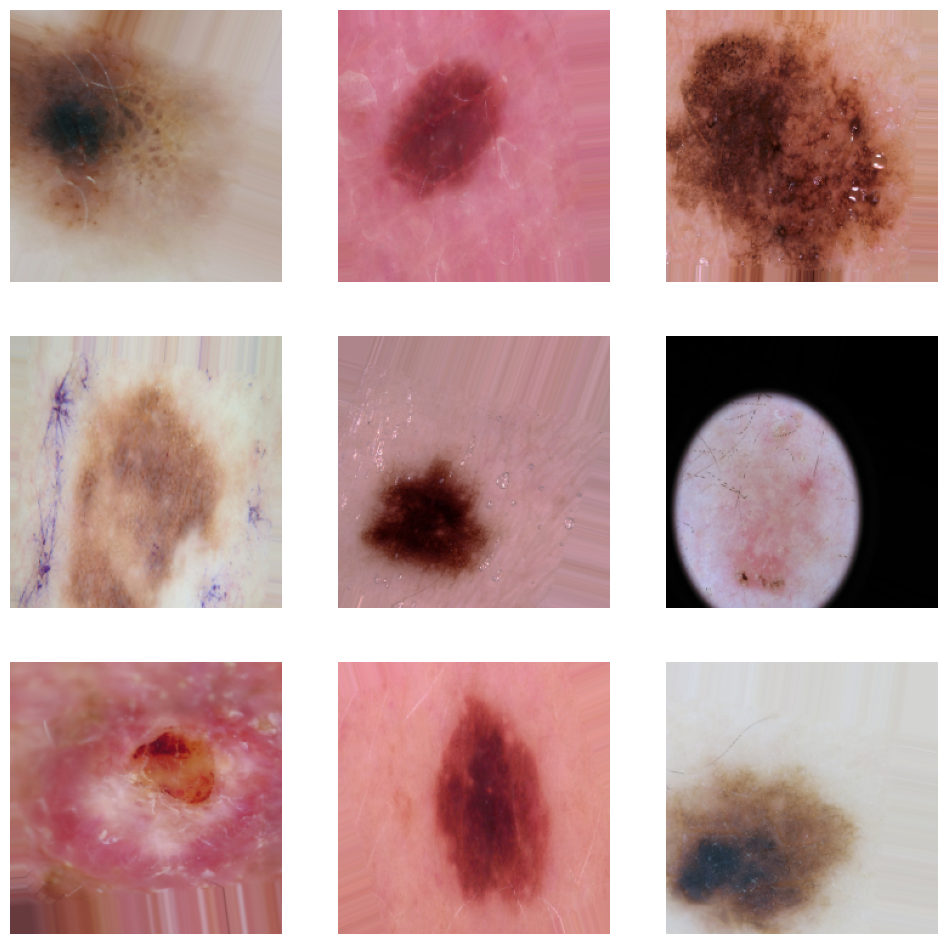

In [11]:
# Display a batch of images
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()

# Modeling

In [13]:
#Build a pretrained ResNet50 model
resnet50 = ResNet50(weights='imagenet',
                   include_top=False, # Allows us to set input shape
                   input_shape=(128,128,3)) 

94765736/94765736 [==============================] - 30s 0us/step


In [14]:
#Add Resnet50 to our pretrained model
resnet50_model = keras.models.Sequential()
resnet50_model.add(resnet50)

#Freezing layers so they don't get re-trained with new data
for layer in resnet50_model.layers:
    layer.trainable=False 
    
#Adding our own dense layers
resnet50_model.add(layers.Flatten())
resnet50_model.add(layers.Dense(128, activation='relu'))

#Output Layer
resnet50_model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
#Summary of our pretrained model
resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 27,782,273
Trainable params: 4,194,561
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
#Compile resnet50 model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of ResNet50
x = base_model.output
x = Flatten()(x)  # Flatten the 2D features to 1D
x = Dense(512, activation='relu')(x)  # Add a dense layer with 512 units
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(128, activation='relu')(x)  # Another dense layer with 128 units
x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting

# Final output layer for classification
predictions = Dense(8, activation='softmax')(x)  # Adjust output for 8 classes

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),  # Use Adam optimizer with lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_resnet50.h5', save_best_only=True, monitor='val_loss')

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=50,  # More epochs, use early stopping
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/50
634/634 [==============================] - 253s 396ms/step - loss: 1.7008 - accuracy: 0.4363 - val_loss: 1.4973 - val_accuracy: 0.5082
Epoch 2/50
634/634 [==============================] - 222s 348ms/step - loss: 1.5777 - accuracy: 0.4939 - val_loss: 1.4878 - val_accuracy: 0.5082
Epoch 3/50
634/634 [==============================] - 222s 350ms/step - loss: 1.5373 - accuracy: 0.5050 - val_loss: 1.4966 - val_accuracy: 0.5082
Epoch 4/50
634/634 [==============================] - 222s 350ms/step - loss: 1.5160 - accuracy: 0.5076 - val_loss: 1.4713 - val_accuracy: 0.5082
Epoch 5/50
634/634 [==============================] - 225s 355ms/step - loss: 1.4978 - accuracy: 0.5082 - val_loss: 1.4825 - val_accuracy: 0.5082
Epoch 6/50
634/634 [==============================] - 289s 456ms/step - loss: 1.4631 - accuracy: 0.5082 - val_loss: 1.4669 - val_accuracy: 0.5082
Epoch 7/50
634/634 [==============================] - 233s 367ms/step - loss: 1.4692 - accuracy: 0.5083 - val_loss: 1.4539 -

In [19]:
# Display the model summary
resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 27,782,273
Trainable params: 4,194,561
Non-trainable params: 23,587,712
_________________________________________________________________


In [28]:
# viwe the model architecture
import pydot
from keras.utils import plot_model
plot_model(resnet50_model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [26]:
# show the predicted labels on some random images from the test set
import random
import numpy as np
import matplotlib.pyplot as plt

# Get a random batch of images and labels
x_batch, y_batch = next(validation_generator)

# Make predictions
y_pred = resnet50_model.predict(x_batch)

# Display the images with their true and predicted labels
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f"True: {y_batch[i]}, Pred: {y_pred[i]:.2f}")
    plt.axis('off')
plt.show()


ValueError: in user code:

    File "C:\ProgramData\anaconda3\envs\CUDAGPU\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\ProgramData\anaconda3\envs\CUDAGPU\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\anaconda3\envs\CUDAGPU\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\ProgramData\anaconda3\envs\CUDAGPU\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\ProgramData\anaconda3\envs\CUDAGPU\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\ProgramData\anaconda3\envs\CUDAGPU\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(32, 224, 224, 3)


In [27]:
#Save Weights
resnet50_model.save_weights('resnet50_model_weights.keras')
resnet50_model.save_weights('resnet50_model_weights.h5')